<a href="https://colab.research.google.com/github/jagratadeb/AI-Mini-Project-Lunar-Landing/blob/main/Lunar_Landing_MAIN_(Deep_Q_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning for Lunar Landing

This Colab notebook showcases a Deep Q-Learning (DQN) agent designed to solve the LunarLander-v3 environment from Gymnasium. The project begins by installing necessary libraries like gymnasium and PyTorch. The core components include a Network class, a feed-forward neural network that approximates the Q-function, and an Agent class which implements the DQN algorithm. This agent utilizes key reinforcement learning techniques: ReplayMemory for experience replay, ensuring stable learning from past interactions; an epsilon-greedy policy for balancing exploration and exploitation; and a target Q-network updated via soft updates to stabilize training. The agent learns to navigate and land the spacecraft by minimizing the mean squared error between predicted and target Q-values. The training loop simulates episodes in the environment, allowing the agent to refine its policy until it consistently achieves successful landings, demonstrating the power of DQN in solving complex control tasks.



## Part 0 - Installing the required packages and importing the libraries

### Installing Gymnasium

In [ ]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!apt-get install -y swig
!pip install gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (828 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

### Importing the libraries

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple

## Part 1 - Building the AI

### Creating the architecture of the Neural Network

In [ ]:
class Network(nn.Module):

  def __init__(self, state_size, action_size, seed = 42):
      super(Network, self).__init__()
      self.seed = torch.manual_seed(seed)
      self.fc1 = nn.Linear(state_size, 64)
      self.fc2 = nn.Linear(64, 64)
      self.fc3 = nn.Linear(64, action_size)

  def forward(self, state):
      x = self.fc1(state)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.relu(x)
      return self.fc3(x)


## Part 2 - Training the AI

### Setting up the environment

In [ ]:
import gymnasium as gym
env = gym.make('LunarLander-v3') # The Lunar Lander environment was upgraded to v3
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


### Initializing the hyperparameters

In [ ]:
learning_rate = 5e-4 #experimental value
minibatch_size = 100 #good size for minibatch for deep Q Learning
discount_factor = 0.99
replay_buffer_size = int(1e5)
interpolation_parameter = 1e-3

### Implementing Experience Replay

In [ ]:
class ReplayMemory(object):

  def __init__(self,capacity):
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.capacity = capacity
      self.memory = []

  def push(self, event):
      self.memory.append(event)
      if len(self.memory) > self.capacity:
        del self.memory[0]

  def sample(self, batch_size):
      experiences = random.sample(self.memory, k = batch_size)
      states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
      actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
      rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
      next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
      dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
      return states, next_states, actions, rewards, dones

### Implementing the DQN class

In [ ]:
class Agent():
  def __init__(self, state_size, action_size):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.state_size = state_size
    self.action_size = action_size

    self.local_qnetwork = Network(state_size, action_size).to(self.device)
    self.target_qnetwork = Network(state_size, action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
    self.memory = ReplayMemory(replay_buffer_size)
    self.t_step = 0

  def step(self, state, action, reward, next_states, done):
    self.memory.push((state, action, reward, next_states, done))
    self.t_step = (self.t_step + 1) % 4
    if self.t_step == 0:
      if len(self.memory.memory) > minibatch_size:
        experiences = self.memory.sample(100)
        self.learn(experiences, discount_factor)

  def act(self, state, epsilon = 0.):
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values = self.local_qnetwork(state)
    self.local_qnetwork.train()
    if random.random() > epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))


  def learn(self, experiences, discount_factor):
    states, next_states, actions, rewards, dones = experiences
    next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + (discount_factor * next_q_targets * (1 - dones))
    q_expected = self.local_qnetwork(states).gather(1,actions)
    loss = F.mse_loss(q_expected,q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)


  def soft_update(self, local_model, target_model,interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

### Initializing the DQN agent

In [ ]:
agent = Agent(state_size, number_actions)

### Training the DQN agent

Episode 100	Average Score: -153.77
Episode 200	Average Score: -100.25
Episode 300	Average Score: -56.82
Episode 400	Average Score: -24.33
Episode 500	Average Score: 90.48
Episode 593	Average Score: 200.98
Environment solved in 493 episodes!	Average Score: 200.98


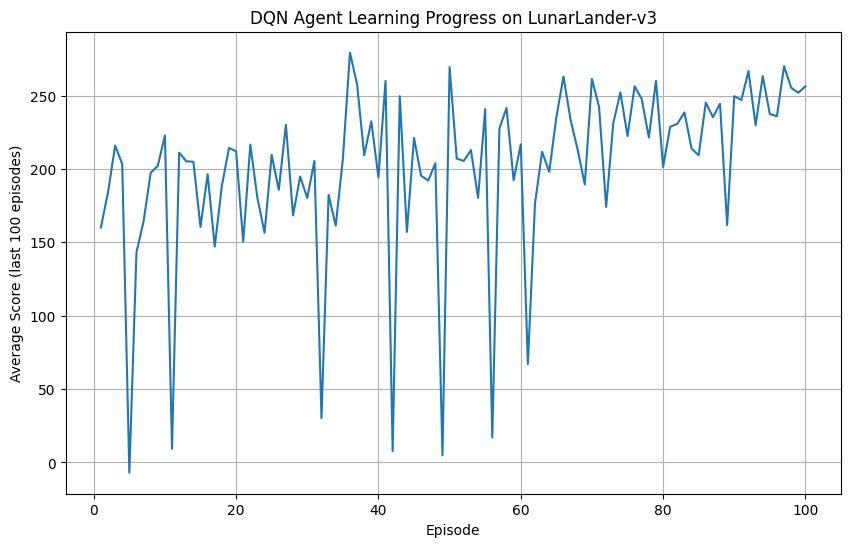

In [ ]:
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value = 1.0
epsilon_ending_value = 0.01
epsilon_decay_value = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)

for episode in range(1, number_episodes + 1):
  state, _ = env.reset()
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if done:
      break
  scores_on_100_episodes.append(score)
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
  if episode % 100 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
  if np.mean(scores_on_100_episodes) >= 200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
    break

import matplotlib.pyplot as plt

# Create a list of episode numbers
episodes_list = range(1, len(scores_on_100_episodes) + 1)

# Plotting the scores
plt.figure(figsize=(10, 6))
plt.plot(episodes_list, list(scores_on_100_episodes))
plt.xlabel('Episode')
plt.ylabel('Average Score (last 100 episodes)')
plt.title('DQN Agent Learning Progress on LunarLander-v3')
plt.grid(True)
plt.show()

## Part 3 - Visualizing the results

In [ ]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=60)

show_video_of_model(agent, 'LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()

## Deep Q-Learning for Lunar Landing 🚀

This project implements a Deep Q-Learning (DQN) agent to solve the Lunar Lander environment from Gymnasium. The goal is to train an agent that can successfully land a spacecraft on a designated landing pad.

**Key Concepts Used:**

- **Reinforcement Learning (RL):** The agent learns by interacting with the environment, receiving rewards for desired actions (like moving towards the landing pad) and penalties for undesirable ones (like crashing).
- **Deep Q-Learning (DQN):** A type of RL that uses a neural network to approximate the optimal Q-function, which estimates the expected future reward for taking a specific action in a given state.
- **Neural Network Architecture:** A simple feed-forward neural network with two hidden layers and ReLU activation functions is used to map the state of the environment (position, velocity, angle, etc.) to the predicted Q-values for each possible action (do nothing, fire left engine, fire main engine, fire right engine).
- **Experience Replay:** A technique where the agent stores its experiences (state, action, reward, next state, done) in a replay buffer and samples random batches from it to train the neural network. This helps to break correlations between consecutive experiences and improves learning stability.
- **Target Network:** A separate neural network with the same architecture as the main network is used to calculate the target Q-values. This target network is updated periodically by copying the weights from the main network, which helps to stabilize the training process.
- **Epsilon-Greedy Policy:** The agent uses an epsilon-greedy policy to balance exploration (trying new actions) and exploitation (choosing the action with the highest predicted Q-value). Epsilon decays over time, encouraging the agent to explore less and exploit more as it learns.
- **Soft Updates:** The target network is updated gradually using a weighted average of its current weights and the weights of the main network. This is a "soft" update compared to a hard copy and further contributes to stable training.
- **Adam Optimizer:** The Adam optimizer is used to update the weights of the neural network based on the calculated loss (Mean Squared Error between the predicted Q-values and the target Q-values).

**Project Steps:**

1.  **Setup:** Install necessary libraries like Gymnasium and PyTorch.
2.  **Build the AI:** Define the neural network architecture.
3.  **Train the AI:**
    *   Set up the Lunar Lander environment.
    *   Initialize hyperparameters for the DQN agent.
    *   Implement the Experience Replay mechanism.
    *   Implement the DQN agent with the `act`, `step`, `learn`, and `soft_update` methods.
    *   Train the agent over multiple episodes, using the epsilon-greedy policy and the experience replay buffer.
4.  **Visualize the results:** (Attempted) Generate a video of the trained agent playing the game.

This project demonstrates how to apply Deep Q-Learning to a classic control problem, showcasing the power of combining neural networks with reinforcement learning techniques to train agents that can learn to perform complex tasks.